In [1]:
import os
import gc

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras import layers

### Convert images from pixals into data, then use pretrained model to accurately classify the stocks
- Mathematical detection algorithms are at best 84% accurate. Goal is to 
- https://www.tensorflow.org/tutorials/images/transfer_learning
- Make a requirements text file
- We do not apply data augmentation because we already have patterns classified as up or down, and flipping them would be counterintuitive

### MobileNet V2 Trained by Google

In [2]:
# Global Variables
BATCH_SIZE = 32
IMG_SIZE = 224

In [3]:
# Paths: For local machine
train_dir = 'C:/Users/Nick/Documents/SchoolStuff/spring2024/machineLearning/final_project/tradingpatterns/stock_patterns/train'
validation_dir = 'C:/Users/Nick/Documents/SchoolStuff/spring2024/machineLearning/final_project/tradingpatterns/stock_patterns/validation'

# train_dir = 'C:/Users/Nick/Desktop/stock images/train'
# validation_dir = 'C:/Users/Nick/Desktop/stock images/validation'

In [4]:
# Create training and validation dataset
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            color_mode='rgb',
                                                            image_size=(IMG_SIZE, IMG_SIZE))

validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 color_mode='rgb',
                                                                 image_size=(IMG_SIZE, IMG_SIZE))
class_names = train_dataset.class_names

Found 6404 files belonging to 4 classes.
Found 5984 files belonging to 4 classes.


In [5]:
type(train_dataset)

tensorflow.python.data.ops.prefetch_op._PrefetchDataset

In [6]:
# Create a test set
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

# Rescale the images from [-1 to 1] vs [0 to 255]
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 150
Number of test batches: 37


In [7]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = (IMG_SIZE, IMG_SIZE) + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [8]:
# This feature extractor converts each 255x255 image into a 5x5x1280 block of features
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)

In [9]:
# Unfreeze this to train
base_model.trainable = False

# Adding a classification head using max
global_max_layer = tf.keras.layers.GlobalMaxPooling2D()
feature_batch_max = global_max_layer(feature_batch)
# print(feature_batch_average.shape)

# Add a dense layer to convert it to a single prediction per image , activation='softmax'
prediction_layer = tf.keras.layers.Dense(len(class_names)) 
prediction_batch = prediction_layer(feature_batch_max)
# print(prediction_batch.shape)

# Process the inputs
inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
# Add the preprocessing layer
x = preprocess_input(inputs)
# Add the base model after, keeping training to false
x = base_model(x, training=False)
# Add max pooling layer
x = global_max_layer(x)
# Add dropout layer
x = tf.keras.layers.Dropout(0.2)(x)
# Add softmax prediction layer
outputs = prediction_layer(x)
# Create a model from inputs, outputs.
model = tf.keras.Model(inputs, outputs)

In [10]:
# model.summary()

https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy

In [11]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), # False when we have a softmax layer
              metrics=['accuracy'])

In [12]:
# loss0, accuracy0 = model.evaluate(validation_dataset)

In [13]:
initial_epochs = 10

history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    steps_per_epoch=5,
                    validation_data=validation_dataset,
                    validation_steps=5)

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 948ms/step - accuracy: 0.2931 - loss: 5.8307 - val_accuracy: 0.3125 - val_loss: 4.7329
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 626ms/step - accuracy: 0.2582 - loss: 4.5211 - val_accuracy: 0.2875 - val_loss: 3.3281
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 638ms/step - accuracy: 0.2516 - loss: 4.4539 - val_accuracy: 0.2562 - val_loss: 2.7595
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 625ms/step - accuracy: 0.2772 - loss: 3.1065 - val_accuracy: 0.2750 - val_loss: 2.2463
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 634ms/step - accuracy: 0.1754 - loss: 3.7813 - val_accuracy: 0.2688 - val_loss: 2.2188
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 623ms/step - accuracy: 0.2163 - loss: 3.8609 - val_accuracy: 0.2812 - val_loss: 2.2311
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 623ms/step - accuracy: 0.2792 - loss: 3.1673 - val_accuracy: 0.3750 - val_loss: 2.3150
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 639ms/step - accuracy: 0.2589 - loss: 3.5251 - val_accuracy: 0.3250 - val_loss:

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']
# 
# plt.figure(figsize=(8, 8))
# plt.subplot(2, 1, 1)
# plt.plot(acc, label='Training Accuracy')
# plt.plot(val_acc, label='Validation Accuracy')
# plt.legend(loc='lower right')
# plt.ylabel('Accuracy')
# plt.ylim([0, .5])
# plt.title('Training and Validation Accuracy')
# 
# plt.subplot(2, 1, 2)
# plt.plot(loss, label='Training Loss')
# plt.plot(val_loss, label='Validation Loss')
# plt.legend(loc='upper right')
# plt.ylabel('Cross Entropy')
# plt.title('Training and Validation Loss')
# plt.xlabel('epoch')
# plt.ylim([0, 10])
# plt.show()

### Customization
1) Feature Extraction
2) Fine-Tuning

In [15]:
base_model.trainable = True

In [16]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 130

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [17]:
# model.summary()

In [18]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate/10),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), # False when we have a Softmax layer
              metrics=['accuracy'])

In [19]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=len(history.epoch),
                         steps_per_epoch=5,
                         validation_data=validation_dataset,
                         validation_steps=5)

Epoch 11/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.2431 - loss: 5.2537 - val_accuracy: 0.2625 - val_loss: 2.1230
Epoch 12/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 680ms/step - accuracy: 0.2418 - loss: 5.2713 - val_accuracy: 0.2625 - val_loss: 2.2297
Epoch 13/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 682ms/step - accuracy: 0.2600 - loss: 4.6308 - val_accuracy: 0.1813 - val_loss: 2.5364
Epoch 14/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 683ms/step - accuracy: 0.2931 - loss: 4.4339 - val_accuracy: 0.3125 - val_loss: 2.2649
Epoch 15/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 684ms/step - accuracy: 0.2688 - loss: 4.6791 - val_accuracy: 0.3125 - val_loss: 2.2298
Epoch 16/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 704ms/step - accuracy: 0.2127 - loss: 4.0561 - val_accuracy: 0.2812 - val_loss: 2.2369
Epoch 17/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 686ms/step - accuracy: 0.2727 - loss: 3.7491 - val_accuracy: 0.3000 - val_loss: 2.2302
Epoch 18/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 689ms/step - accuracy: 0.2706 - loss: 3.9200 - val_accuracy: 0.2313 - val

In [20]:
# loss, accuracy = model.evaluate(test_dataset)
# print('Test accuracy :', accuracy)

In [21]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

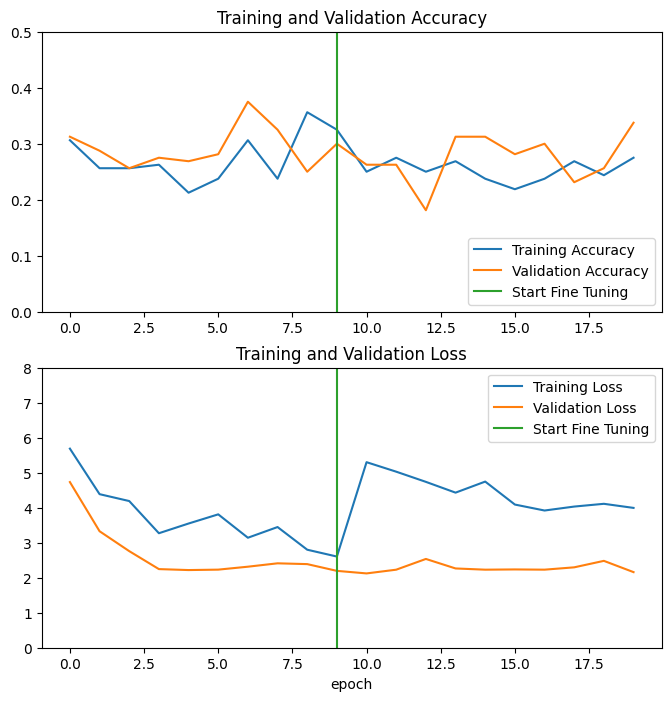

In [28]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, .5])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 8.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [23]:
# Add a softmax layer to our model and apply our test data
probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = probability_model.predict(image_batch)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


In [24]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d            │ (None, 1280)           │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │         5,124 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,993,358 (19.05 MB)

 Trainable params: 1,365,124 (5.21 MB)

 Non-trainable params: 897,984 (3.43 MB)

 Optimizer params: 2,730,250 (10.42 MB)

In [25]:
# plt.figure(figsize=(10, 10))
# for i in range(9):
#   ax = plt.subplot(3, 3, i + 1)
#   plt.imshow(image_batch[i].astype("uint8"))
#   guess = str(class_names[np.argmax(predictions[i+9])])
#   actual = str(class_names[label_batch[i+9]])
#   title = "Prediction: " + guess + "\n" + "Actual: " + actual
#   plt.title(title)
#   plt.axis("off")